In [63]:
import pandas as pd
from scipy.spatial import distance
import os
# time
import pytz
import datetime
# plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as po
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
# maths and statistics
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from scipy.stats import kstest,ks_2samp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
# process mining
import pm4py
from pm4py.objects.log.importer import xes
from pm4py.objects.conversion.log.versions import to_dataframe
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
# warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
wd = os.getcwd()
"""
get all filenames in working directory
then collect log containing folders
get log files paths and collect logs

"""
logs_paths = []
for file in os.listdir(wd):
    if file.endswith(".xes_"):
        for f in os.listdir(file):
            if f.endswith(".xes"):
                logs_paths.append(os.path.join(wd+'\\'+file, f))
print(logs_paths)

['C:\\PM contest\\Common challenge\\DomesticDeclarations.xes_\\DomesticDeclarations.xes', 'C:\\PM contest\\Common challenge\\InternationalDeclarations.xes_\\InternationalDeclarations.xes', 'C:\\PM contest\\Common challenge\\PermitLog.xes_\\PermitLog.xes', 'C:\\PM contest\\Common challenge\\PrepaidTravelCost.xes_\\PrepaidTravelCost.xes', 'C:\\PM contest\\Common challenge\\RequestForPayment.xes_\\RequestForPayment.xes']


### Таблицы

In [3]:
domestic_declarations = xes_importer.apply(wd + '\DomesticDeclarations.xes_\DomesticDeclarations.xes')

In [4]:
int_declarations = xes_importer.apply(wd + '\InternationalDeclarations.xes_\InternationalDeclarations.xes')

In [5]:
permit_log = xes_importer.apply(wd + '\PermitLog.xes_\PermitLog.xes')

In [6]:
prepaid_travel_cost = xes_importer.apply(wd + '\PrepaidTravelCost.xes_\PrepaidTravelCost.xes')

In [7]:
request_for_payment = xes_importer.apply(wd + '\RequestForPayment.xes_\RequestForPayment.xes')

In [8]:
permit_log = pd.read_csv('C://PM contest//Common challenge//PermitLog.xes_//compact_PermitLog.csv')
permit_log['time:timestamp']=permit_log['time:timestamp'].map(lambda x: datetime.datetime.fromisoformat(x))

In [9]:
domestic_declarations = to_dataframe.apply(domestic_declarations)
int_declarations = to_dataframe.apply(int_declarations)
permit_log = to_dataframe.apply(permit_log)
prepaid_travel_cost = to_dataframe.apply(prepaid_travel_cost)
request_for_payment = to_dataframe.apply(request_for_payment)

In [10]:
dfs_list = [domestic_declarations,int_declarations,permit_log,prepaid_travel_cost,request_for_payment]

### Timestamp with timezone --> timestamp unified

In [11]:
"""
converts to UTC-format for unified timestamp format
:param: df - selected table
:param: time_column - column with the following time format %Y-%m-%d HH:MM:SS+0X:00
:return: converted to UTC-format timestmp without timezone
"""

def to_utc(df, time_column):
    utc = pytz.timezone('UTC')
    df[time_column] = df[time_column].map(lambda x: x.astimezone(utc).replace(tzinfo=None))
    return df

In [12]:
for df in dfs_list:
    df = to_utc(df, 'time:timestamp')

### 3. Is there are difference in throughput between national and international trips?

In [13]:
def time_period_selection(df, start_date, end_date, time_column):
    df = df[(df[time_column]>=start_date)&(df[time_column]<=end_date)]
    return df

In [595]:
td_17 = time_period_selection(domestic_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
td_18 = time_period_selection(domestic_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

ti_17 = time_period_selection(int_declarations,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
ti_18 = time_period_selection(int_declarations,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

rp_17 = time_period_selection(request_for_payment,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
rp_18 = time_period_selection(request_for_payment,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

pl_17 = time_period_selection(permit_log,
                      '2017-01-01 00:00:00',
                      '2017-12-31 23:59:59',
                      'time:timestamp')
pl_18 = time_period_selection(permit_log,
                      '2018-01-01 00:00:00',
                      '2018-12-31 23:59:59',
                      'time:timestamp')

In [596]:
permit_log['case:id'].head()

0    travel permit 76455
1    travel permit 76455
2    travel permit 76455
3    travel permit 76455
4    travel permit 76455
Name: case:id, dtype: object

In [597]:
dd_17 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_17['case:id']))].reset_index(drop=True)
dd_18 = domestic_declarations[domestic_declarations['case:id'].isin(set(td_18['case:id']))].reset_index(drop=True)

id_17 = int_declarations[int_declarations['case:id'].isin(set(ti_17['case:id']))].reset_index(drop=True)
id_18 = int_declarations[int_declarations['case:id'].isin(set(ti_18['case:id']))].reset_index(drop=True)

rp_17 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))].reset_index(drop=True)
rp_18 = request_for_payment[request_for_payment['case:Rfp_id'].isin(set(rp_18['case:Rfp_id']))].reset_index(drop=True)

pl_17 = permit_log[permit_log['case:id'].isin(set(pl_17['case:id']))].reset_index(drop=True)
pl_18 = permit_log[permit_log['case:id'].isin(set(pl_18['case:id']))].reset_index(drop=True)

In [598]:
dd_18 = dd_18[~dd_18['case:id'].isin(set(dd_17['case:id']))]
id_18 = id_18[~id_18['case:id'].isin(set(id_17['case:id']))]

rpf_18 = rp_18[~rp_18['case:Rfp_id'].isin(set(rp_17['case:Rfp_id']))]
pl_18 = pl_18[~pl_18['case:id'].isin(set(pl_17['case:id']))]

In [599]:
len(set(dd_17['case:id'])), len(set(dd_18['case:id']))

(2240, 8260)

In [600]:
len(set(id_17['case:id'])), len(set(id_18['case:id']))

(1552, 4897)

### Кластеризация процессов 

> Label encoder'ом перевела в цифры все состояния, которые есть в столбце case:concept, полученные значения перевела в стобцы вида col_(порядковый номер признака) и дальше по каждой декларации проставляла 0 - если нет этого этапа, 1 - если есть. Потом я взяла эти признаки как отдельные пространства и спроецировала на плоскость. Можешь попробовать РСА, но я попробовала - никаких инсайтов. Отлично работает TSNE. Дальше, когда мы спроецировали на плоскость, можем проводить кластерный анализ: DBSCAN, KMeans, Hierarchical Clustering, Spectral и прочие.
https://scikit-learn.org/stable/modules/clustering.html
Я бы пофайнтюнила DBSCAN, KMeans

In [309]:
def tsne_projecting(d_frame, concept_name_column, case_id_column):
    le = preprocessing.LabelEncoder()
    le.fit(list(set(d_frame[concept_name_column])))
    outlier_label = len(list(set(d_frame[concept_name_column])))+2
    d_frame['concept:name:label']=le.transform(d_frame[concept_name_column].to_list())
    vectors_dd = pd.DataFrame(d_frame.groupby([case_id_column])['concept:name:label'].apply(lambda x: list(x)))
    vectors_dd['length'] = vectors_dd['concept:name:label'].map(lambda x: len(x))
    max_ = vectors_dd['length'].max()
    labels_set = set(d_frame['concept:name:label'])
    new_vecs = []
    for i in range(len(vectors_dd)):
        small_ = []
        for j in labels_set:
            if j in vectors_dd['concept:name:label'].iloc[i]:
                small_.append(1)
            else:
                small_.append(0)
        new_vecs.append(small_)
    vectors_dd['new_vecs'] = new_vecs
    column_names = []
    for i in range(len(labels_set)):
        name = 'col_'+str(i)
        column_names.append(name)
    for i in column_names:
        num = int(i.split('_')[-1])
        vectors_dd[i] = None
        list_ = []
        for j in range(len(vectors_dd)):
            list_.append(vectors_dd['new_vecs'].iloc[j][num])
        vectors_dd[i]=list_
    # clustering
    vectors_dd = vectors_dd.reset_index()
    X = vectors_dd[column_names].values
    tsne = TSNE(random_state=17)
    tsne_representation = tsne.fit_transform(X)
    return X, tsne_representation, vectors_dd

In [612]:
X_dd_18, tsne_representation_dd_18, vectors_dd_18 = tsne_projecting(dd_18, 'concept:name', 'case:id')
#X_id_18, tsne_representation_id_18, vectors_id_18 = tsne_projecting(id_18, 'concept:name', 'case:id')
#X_rp_18, tsne_representation_rp_18, vectors_rp_18 = tsne_projecting(rpf_18, 'concept:name', 'case:Rfp_id')
X_pl_18, tsne_representation_pl_18, vectors_pl_18 = tsne_projecting(pl_18, 'concept:name', 'case:id')

In [613]:
tdf_dd_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
tdf_dd_18['tsne_1'] = tsne_representation_dd_18[:,0]
tdf_dd_18['tsne_2'] = tsne_representation_dd_18[:,1]

#tdf_id_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_id_18['tsne_1'] = tsne_representation_id_18[:,0]
#tdf_id_18['tsne_2'] = tsne_representation_id_18[:,1]

#tdf_rp_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
#tdf_rp_18['tsne_1'] = tsne_representation_rp_18[:,0]
#tdf_rp_18['tsne_2'] = tsne_representation_rp_18[:,1]

tdf_pl_18 = pd.DataFrame(columns= ['tsne_1','tsne_2'])
tdf_pl_18['tsne_1'] = tsne_representation_pl_18[:,0]
tdf_pl_18['tsne_2'] = tsne_representation_pl_18[:,1]

### K-means

In [614]:
from sklearn.cluster import KMeans

In [615]:
disortions = []
K = range(1,10)
for k in K:
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(tdf_id_18[['tsne_1','tsne_2']].values)
    disortions.append(kmean_model.inertia_)

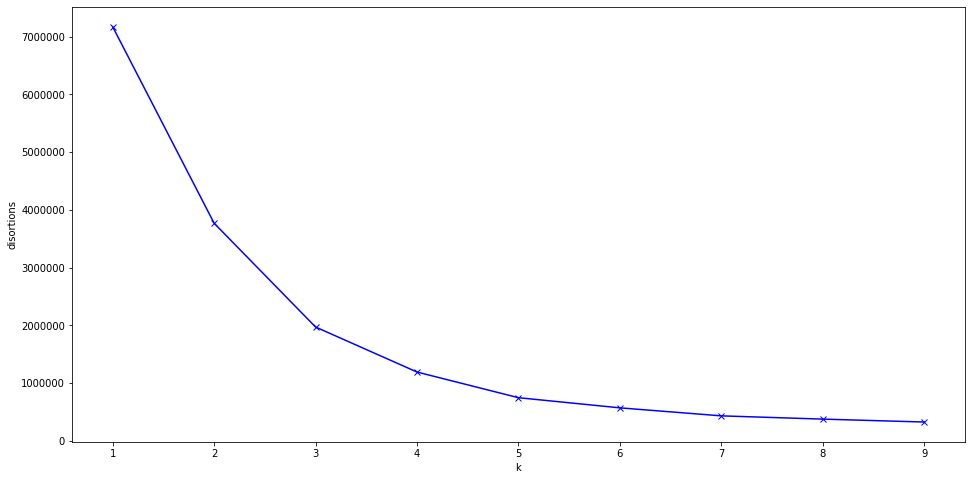

In [616]:
plt.figure(figsize=(16,8))
plt.plot(K, disortions, 'bx-')
plt.xlabel('k'),
plt.ylabel('disortions')
plt.show()

In [386]:
len(tdf_id_18[['tsne_1', 'tsne_2']])

4897

In [387]:
#kmean_model = KMeans(n_clusters = 4)
#kmean_model.fit(tdf_dd_18)
#tdf_dd_18['KMeans_label'] = kmean_model.labels_

kmean_model = KMeans(n_clusters = 4)
kmean_model.fit(tdf_id_18[['tsne_1', 'tsne_2']].values)
tdf_id_18['KMeans_label'] = kmean_model.labels_

In [388]:
kmean_model.cluster_centers_

array([[-42.056835  ,  22.401133  ],
       [-20.23328   , -24.439175  ],
       [ 20.747234  ,  -5.5719614 ],
       [ -0.34182143,  50.217033  ]], dtype=float32)

### Для поиска оптимального eps DBSCAN

In [389]:
def eps_search(n, X):
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    return distances

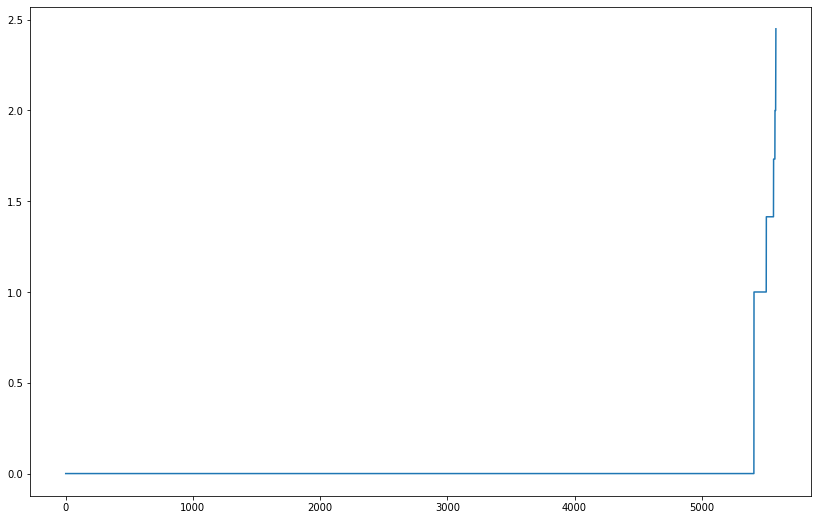

In [618]:
d = eps_search(2, X_pl_18)

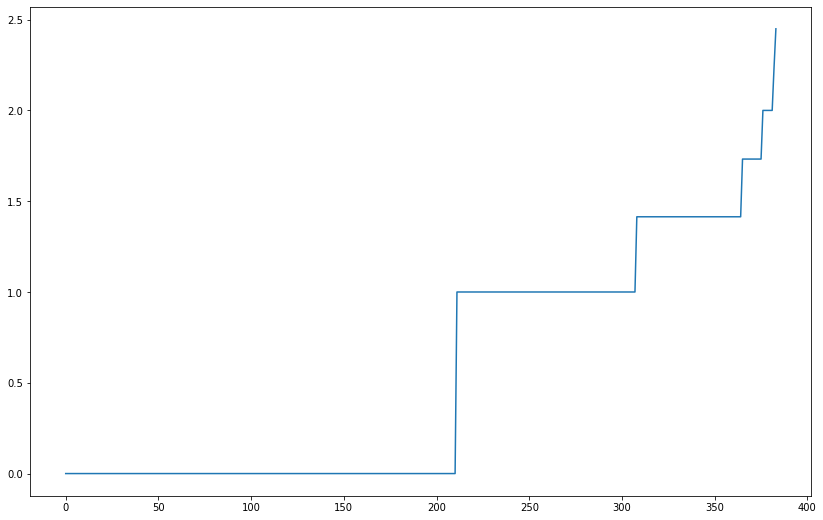

In [604]:
plt.plot(d[5200:])

### DBSCAN

> В DBSCAN мы в eps очерчиваем радиус окружности, а в min samples указваыем количество соседей в окружности, после чего мы такой кейс посчитаем кластером.


In [621]:
# Для домашних деклараций я фиксировала эти
#cluster = DBSCAN(eps = 0.5, min_samples = 80).fit(X_dd_18)
#tdf_dd_18['DBSCAN_label'] = cluster.labels_

# международные
cluster = DBSCAN(eps = 0.01, min_samples = 80).fit(X_pl_18)
tdf_pl_18['DBSCAN_label'] = cluster.labels_

In [620]:
fig = px.scatter(tdf_dd_18, x = tsne_representation_dd_18[:, 0], y = tsne_representation_dd_18[:, 1],
                color = tdf_dd_18['DBSCAN_label'].to_list(),
                height = 800, width = 800,
                title = "DBSCAN domestic")
fig.update_layout(font_size =15)
#fig.show()

In [608]:
fig = px.scatter(tdf_rp_18, x = tsne_representation_rp_18[:, 0], y = tsne_representation_rp_18[:, 1],
                color = tdf_rp_18['DBSCAN_label'].to_list(),
                height = 800, width = 800,
                title = "DBSCAN requests for payment")
fig.update_layout(font_size =15)
#fig.show()

In [610]:
fig = px.scatter(tdf_id_18, x = tsne_representation_id_18[:, 0], y = tsne_representation_id_18[:, 1],
                color = tdf_id_18['DBSCAN_label'].to_list(),
                height = 800, width = 800,
                title = "DBSCAN international")
fig.update_layout(font_size =15)
#fig.show()

In [609]:
fig = px.scatter(tdf_pl_18, x = tsne_representation_pl_18[:, 0], y = tsne_representation_pl_18[:, 1],
                color = tdf_pl_18['DBSCAN_label'].to_list(),
                height = 800, width = 800,
                title = "DBSCAN permit log")
fig.update_layout(font_size =15)
#fig.show()

In [407]:
tdf_id_18['case:id'] = vectors_id_18['case:id']

In [408]:
tdf_id_18['DBSCAN_label'].value_counts()

 0    1738
-1    1028
 1     866
 2     442
 3     313
 5     149
 4      99
 7      90
 8      90
 6      82
Name: DBSCAN_label, dtype: int64

In [395]:
selected_pl = permit_log[permit_log['case:travel permit number']=='travel permit number 424'].reset_index(drop = True)

In [476]:
third_cluster = int_declarations[int_declarations['case:concept:name'].isin(
    set(tdf_id_18[(tdf_id_18['DBSCAN_label']==0)]['case:id']))].reset_index(drop=True)

In [477]:
third_cluster.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Permit travel permit number', 'case:DeclarationNumber',
       'case:Amount', 'case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount'],
      dtype='object')

In [478]:
third_cluster.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,rv_travel permit 16320_6,STAFF MEMBER,Start trip,2018-01-01 23:00:00,EMPLOYEE,travel permit number 16321,declaration number 16323,1353.55241,1353.55241,task 427,...,declaration 16322,organizational unit 65458,travel permit number 16321,901.275818,declaration 16322,travel permit 16320,travel permit 16320,budget 145484,UNKNOWN,1353.55241
1,rv_travel permit 16320_7,STAFF MEMBER,End trip,2018-01-06 23:00:00,EMPLOYEE,travel permit number 16321,declaration number 16323,1353.55241,1353.55241,task 427,...,declaration 16322,organizational unit 65458,travel permit number 16321,901.275818,declaration 16322,travel permit 16320,travel permit 16320,budget 145484,UNKNOWN,1353.55241
2,st_step 16326_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2018-01-08 19:17:03,EMPLOYEE,travel permit number 16321,declaration number 16323,1353.55241,1353.55241,task 427,...,declaration 16322,organizational unit 65458,travel permit number 16321,901.275818,declaration 16322,travel permit 16320,travel permit 16320,budget 145484,UNKNOWN,1353.55241
3,st_step 16324_0,STAFF MEMBER,Permit APPROVED by ADMINISTRATION,2018-01-08 19:17:08,ADMINISTRATION,travel permit number 16321,declaration number 16323,1353.55241,1353.55241,task 427,...,declaration 16322,organizational unit 65458,travel permit number 16321,901.275818,declaration 16322,travel permit 16320,travel permit 16320,budget 145484,UNKNOWN,1353.55241
4,st_step 16325_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2018-01-09 11:01:54,SUPERVISOR,travel permit number 16321,declaration number 16323,1353.55241,1353.55241,task 427,...,declaration 16322,organizational unit 65458,travel permit number 16321,901.275818,declaration 16322,travel permit 16320,travel permit 16320,budget 145484,UNKNOWN,1353.55241


In [479]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [480]:
# прямой граф
log = conversion_factory.apply(third_cluster)
dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log)
gviz = dfg_vis_factory.apply(dfg, log=log)
#gviz.render("first")

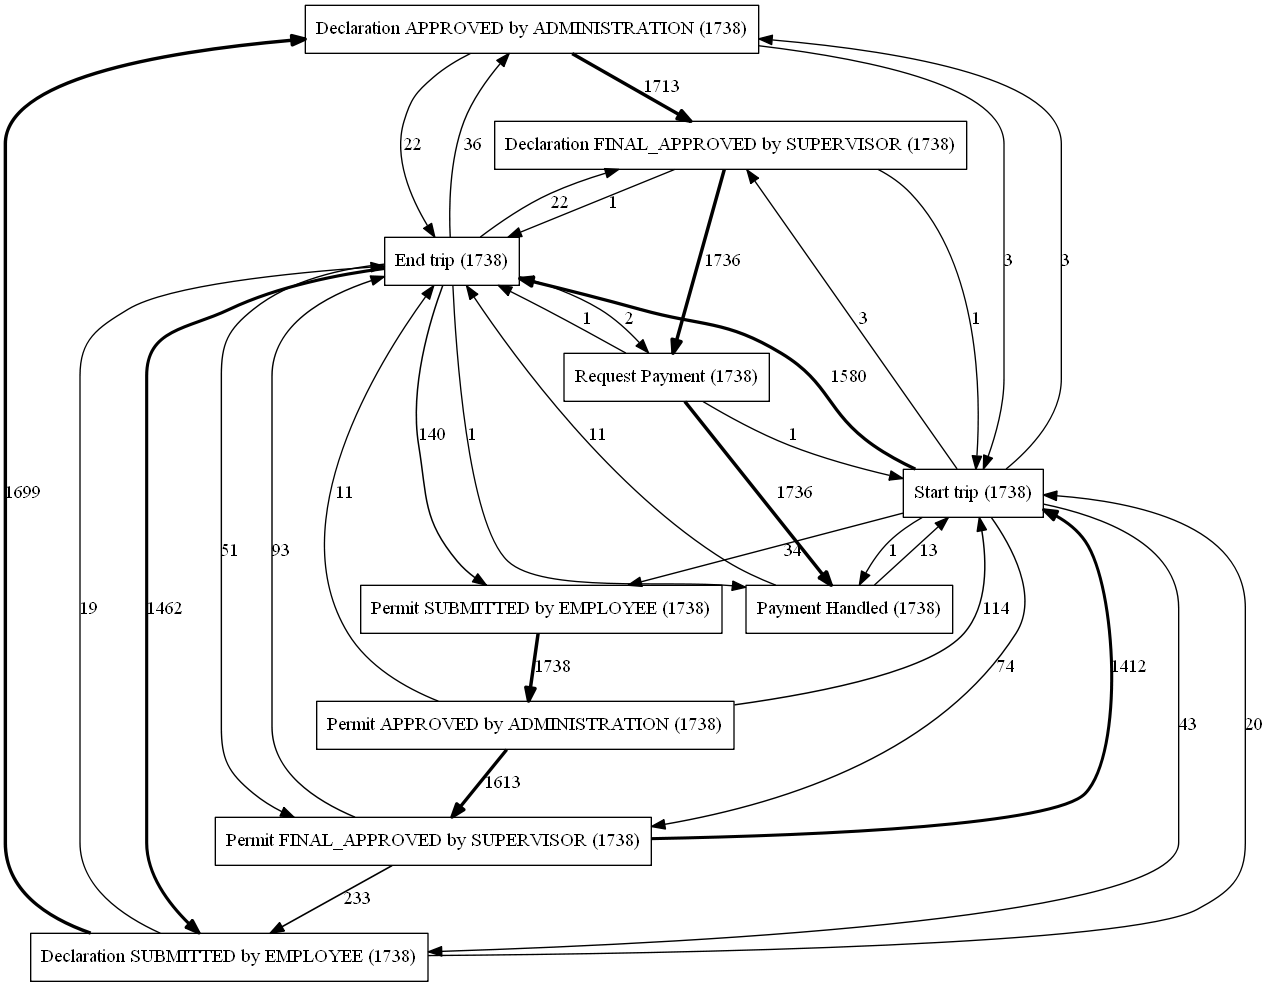

In [481]:
dfg_vis_factory.view(gviz)

In [482]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner

In [483]:
heu_net = heuristics_miner.apply_heu(log, parameters={"min_act_count":10})
                                                      #"dfg_pre_cleaning_noise_thresh":0.05})

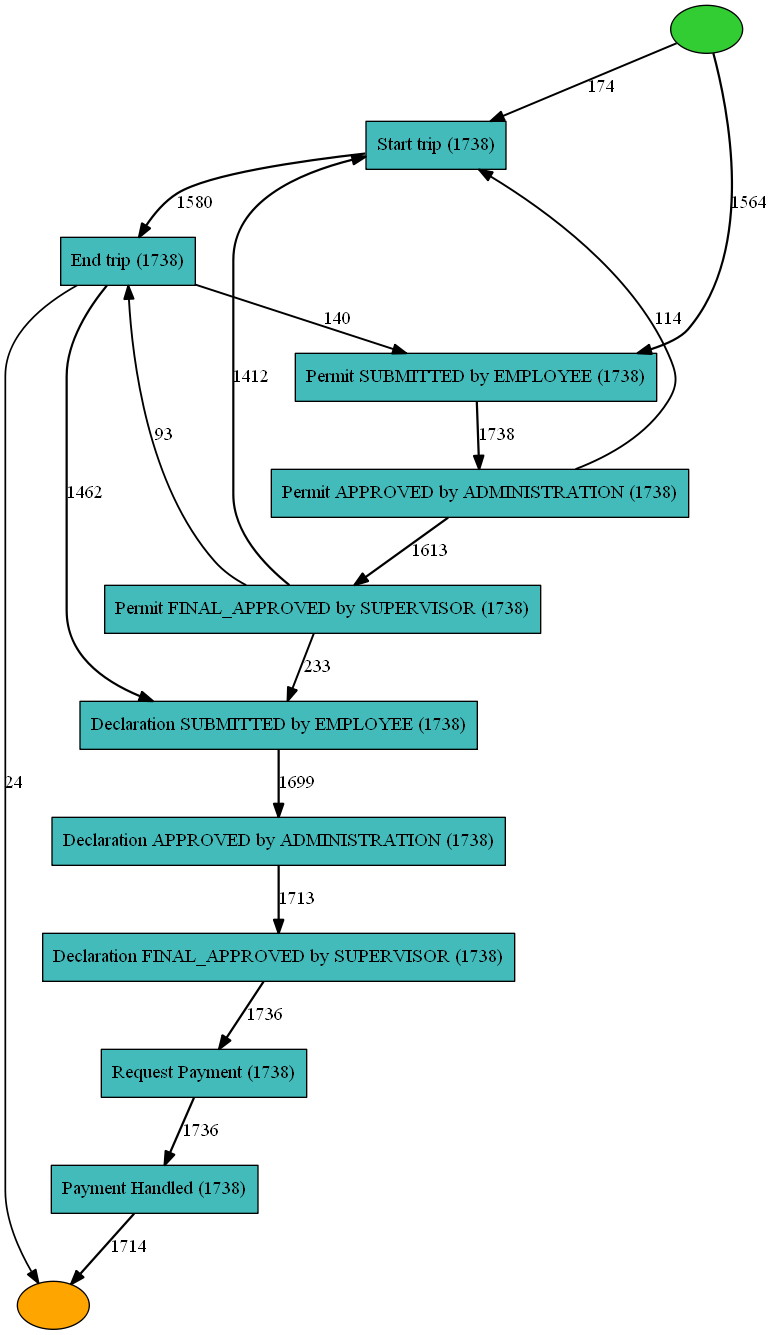

In [484]:
from pm4py.visualization.heuristics_net import factory as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)

### Hierarchical Clustering

In [427]:
import scipy
from scipy.spatial.distance import pdist

In [539]:
X = scipy.spatial.distance.squareform(pdist(tsne_representation_id_18, 'cityblock'))

In [550]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='single')
cluster.fit(X)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=10)

In [551]:
len(cluster.labels_)

4897

In [552]:
tdf_id_18['Agglomerative_label'] = cluster.labels_

In [553]:
tdf_id_18['Agglomerative_label'].value_counts()

4    1747
6    1003
1     925
3     402
0     299
2     243
8     160
5      54
7      42
9      22
Name: Agglomerative_label, dtype: int64

In [554]:
fig = px.scatter(tdf_id_18, x = tsne_representation_id_18[:, 0], y = tsne_representation_id_18[:, 1],
                color = tdf_id_18['Agglomerative_label'].to_list(),
                height = 800, width = 800,
                title = "Agglomerative international")
fig.update_layout(font_size =15)
#fig.show()

In [588]:
third_cluster = int_declarations[int_declarations['case:concept:name'].isin(
    set(tdf_id_18[(tdf_id_18['Agglomerative_label']==9)]['case:id']))].reset_index(drop=True)

In [589]:
# прямой граф
log = conversion_factory.apply(third_cluster)
dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log)
gviz = dfg_vis_factory.apply(dfg, log=log)
#gviz.render("first")

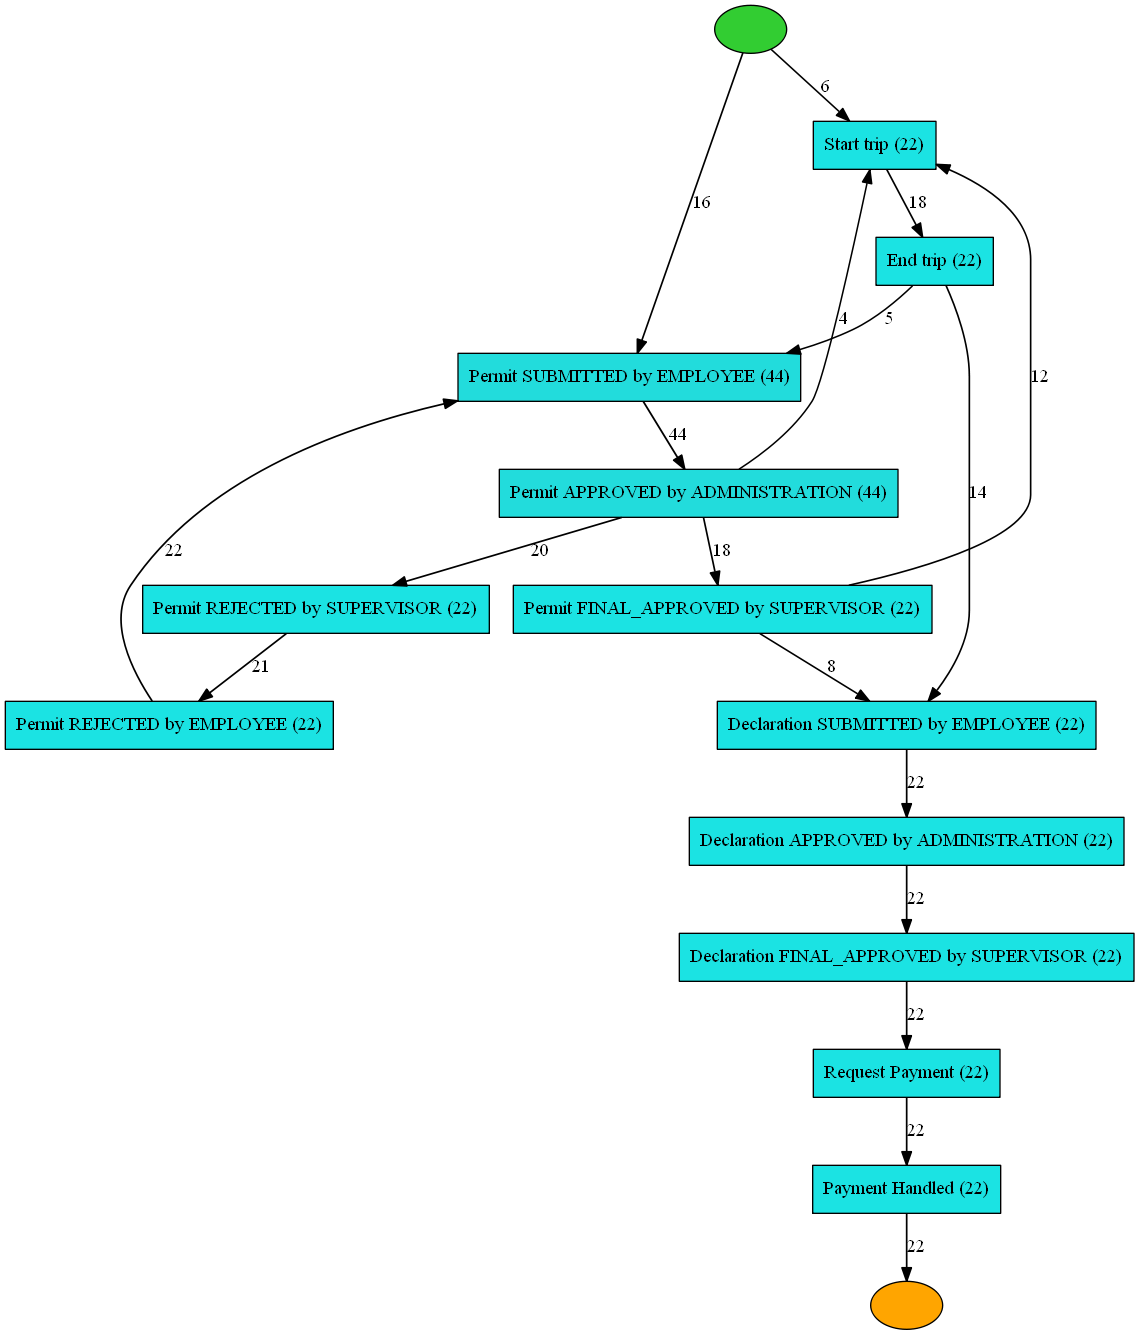

In [590]:
heu_net = heuristics_miner.apply_heu(log, parameters={"min_act_count":20,
                                                      "dfg_pre_cleaning_noise_thresh":0.20})

gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)


In [487]:
id_18.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Permit travel permit number', 'case:DeclarationNumber',
       'case:Amount', 'case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount', 'concept:name:label'],
      dtype='object')

#### Distribution of declarations on projects

In [497]:
declarations_on_projects = pd.DataFrame(id_18.groupby(['case:Permit ProjectNumber'])['case:id'].nunique())

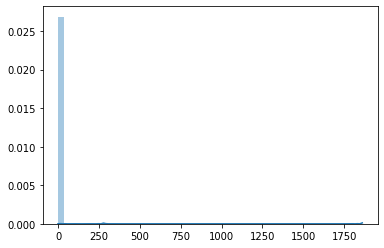

In [498]:
import seaborn as sns
sns.distplot(declarations_on_projects['case:id'].to_list())

In [500]:
declarations_on_projects.sort_values(['case:id'], ascending = False)

,case:id
case:Permit ProjectNumber,
UNKNOWN,1858
project 426,282
project 1623,27
project 1115,26
project 1185,26
...,...
project 48747,1
project 48605,1
project 48562,1


In [501]:
clear = declarations_on_projects[(declarations_on_projects['case:id']!=1858)&(declarations_on_projects['case:id']!=282)]

In [522]:
clear.sort_values(['case:id'], ascending = True)

,case:id
case:Permit ProjectNumber,
project 33979,1
project 42226,1
project 17377,1
project 56318,1
project 26728,1
...,...
project 981,22
project 3442,24
project 1115,26


In [507]:
pl.rcParams['figure.figsize'] = (14, 9)

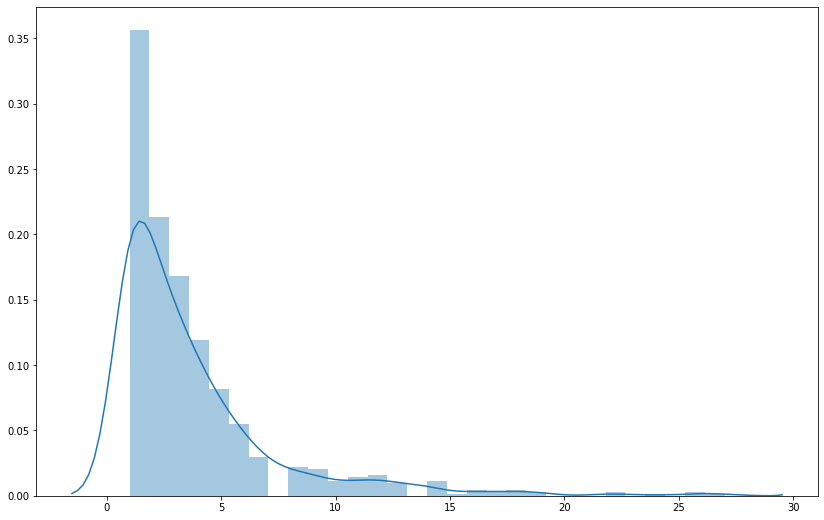

In [523]:
sns.distplot(clear['case:id'].to_list())

### Double payments

In [509]:
id_18['concept:name'].value_counts()

Declaration SUBMITTED by EMPLOYEE           6334
End trip                                    4897
Start trip                                  4897
Declaration APPROVED by ADMINISTRATION      4817
Permit SUBMITTED by EMPLOYEE                4803
Permit APPROVED by ADMINISTRATION           4722
Payment Handled                             4687
Request Payment                             4683
Declaration FINAL_APPROVED by SUPERVISOR    4543
Permit FINAL_APPROVED by SUPERVISOR         4212
Declaration APPROVED by BUDGET OWNER        1773
Permit APPROVED by BUDGET OWNER             1715
Declaration REJECTED by EMPLOYEE            1621
Declaration REJECTED by ADMINISTRATION      1512
Permit APPROVED by SUPERVISOR                420
Permit FINAL_APPROVED by DIRECTOR            419
Send Reminder                                393
Permit REJECTED by EMPLOYEE                  169
Declaration APPROVED by SUPERVISOR           145
Declaration FINAL_APPROVED by DIRECTOR       144
Declaration REJECTED

In [518]:
double_payments = pd.DataFrame(id_18[id_18['concept:name']=='Payment Handled'].groupby(['case:id'])['concept:name'].apply(lambda x: list(x)))

In [519]:
double_payments['concept:name_length'] = double_payments['concept:name'].map(lambda x: len(x))

In [520]:
double_payments[double_payments['concept:name_length']>1]

,concept:name,concept:name_length
case:id,,
